state vector dim = 2
n_actions = 3


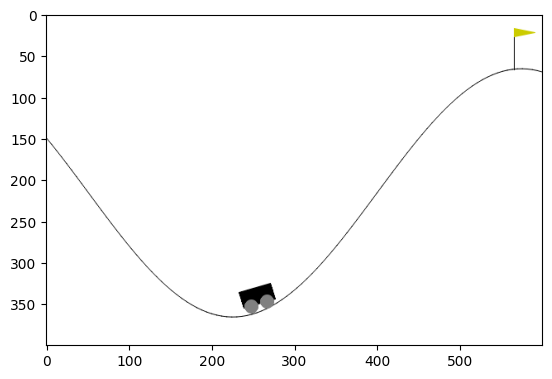

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [2]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(100, 100),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100))

In [3]:
def generate_session(env, agent, t_max=10000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [4]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] > reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    if len(elite_states) == 0:
        for i in range(len(rewards_batch)):
            if rewards_batch[i] >= reward_threshold:
                elite_states.extend(states_batch[i])
                elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions


In [5]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = -144.440, threshold=-120.700


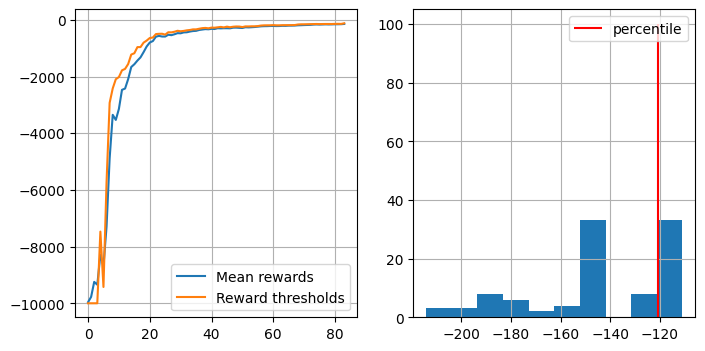

You Win! You may stop training now via KeyboardInterrupt.


In [6]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    # states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break


In [7]:
agent = MLPClassifier(
    hidden_layer_sizes=(100, 100),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

env = gym.make("MountainCar-v0", render_mode="rgb_array").env


mean reward = -140.200, threshold=-123.000


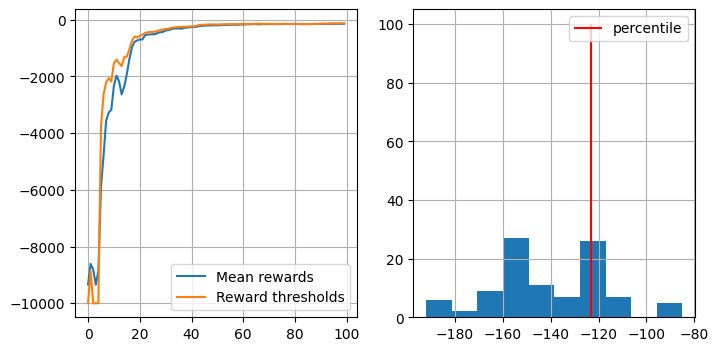

In [9]:
from joblib import Parallel, delayed

n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    # sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    sessions = Parallel()(delayed(generate_session)(env, agent) for _ in range(n_sessions))

    # states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > -100:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break


In [10]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("MountainCar-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


d:\repos\RL\venv\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at d:\repos\RL\HW2\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-0.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-0.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-1.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-1.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-2.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-2.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-3.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-3.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-4.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-4.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-5.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-5.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-6.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-6.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-7.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-7.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-8.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-8.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-9.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-9.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-10.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-10.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-11.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-11.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-12.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-12.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-13.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-13.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-14.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-14.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-15.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-15.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-16.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-16.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-17.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-17.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-18.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-18.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-19.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-19.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-20.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-20.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-21.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-21.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-22.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-22.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-23.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-23.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-24.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-24.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-25.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-25.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-26.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-26.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-27.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-27.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-28.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-28.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-29.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-29.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-30.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-30.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-31.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-31.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-32.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-32.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-33.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-33.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-34.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-34.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-35.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-35.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-36.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-36.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-37.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-37.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-38.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-38.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-39.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-39.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-40.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-40.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-41.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-41.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-42.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-42.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-43.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-43.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-44.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-44.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-45.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-45.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-46.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-46.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-47.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-47.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-48.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-48.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-49.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-49.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-50.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-50.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-51.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-51.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-52.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-52.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-53.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-53.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-54.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-54.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-55.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-55.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-56.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-56.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-57.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-57.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-58.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-58.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-59.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-59.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-60.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-60.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-61.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-61.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-62.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-62.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-63.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-63.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-64.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-64.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-65.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-65.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-66.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-66.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-67.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-67.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-68.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-68.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-69.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-69.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-70.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-70.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-71.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-71.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-72.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-72.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-73.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-73.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-74.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-74.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-75.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-75.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-76.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-76.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-77.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-77.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-78.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-78.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-79.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-79.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-80.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-80.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-81.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-81.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-82.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-82.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-83.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-83.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-84.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-84.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-85.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-85.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-86.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-86.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-87.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-87.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-88.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-88.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-89.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-89.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-90.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-90.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-91.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-91.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-92.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-92.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-93.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-93.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-94.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-94.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-95.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-95.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-96.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-96.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-97.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-97.mp4
Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-98.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-98.mp4


Moviepy - Building video d:\repos\RL\HW2\videos\rl-video-episode-99.mp4.
Moviepy - Writing video d:\repos\RL\HW2\videos\rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready d:\repos\RL\HW2\videos\rl-video-episode-99.mp4


In [11]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices


data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)
